In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# TODO: Images in the latent space plot, and then images on test (need to supply them as goals)


In [2]:
import argparse


parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('--bulk_datasets', nargs='+', help='data diversity dataset names')
parser.add_argument('--video_datasets', nargs='+', help='for contrastive learning')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=50, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=2048, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-lg', '--goal_mapper_layer_size', default=512, type=int, help='Layer size of goal mapping networks from im and sent to goal space, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-s_embd', '--sentence_embedding_size', default=512, type=int, help='Embedding size of MUSE sentence embeddings')
parser.add_argument('-g_embd', '--gripper_img_embedding_size', default=32, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-zg', '--goal_space_dim', default=32, type=int, help='Size of the goal embedding space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('-i2', '--images2', default=False, action='store_true')
parser.add_argument('-gi', '--gripper_images', default=False, action='store_true')
parser.add_argument('-cnn', '--cnn_type', type=str, default="spatial_softmax")
parser.add_argument('-sim', '--sim', default='Unity', help='Unity/Pybullet')
parser.add_argument('-vq', '--discrete', default=False, action='store_true')
parser.add_argument('-cb', '--codebook_size', type=int, default=128)
parser.add_argument('-cm', '--commitment_loss', type=float, default=1)
parser.add_argument('-tmp', '--temperature', type=float, default=0.1)
parser.add_argument('--vq_tiles', type=int, default=5) # split into 5 tiles, must cleanly divide into max_seq_len
parser.add_argument('-nm', '--normalize', default=False, action='store_true')
parser.add_argument('-lang', '--use_language', default=False, action='store_true')
parser.add_argument('-cont', '--use_contrastive', default=False, action='store_true')
parser.add_argument('-enc_all', '--encode_all', default=False, action='store_true', help='encode_actions_and_proprio not just imgs')
parser.add_argument('-sub', '--sub_out_language_percent',  type=float, default=0.25)
parser.add_argument('--fp16', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP
# Set these to split the dataset up so we control the proportion of lang vs bulk vs video etc - make them batch numbers 
parser.add_argument('-ss', '--standard_split', type=int, default=0)
parser.add_argument('-bs', '--bulk_split', type=int, default=0)
parser.add_argument('-ls', '--lang_split', type=int, default=0)
parser.add_argument('-vs', '--video_split', type=int, default=0)



_StoreAction(option_strings=['-vs', '--video_split'], dest='video_split', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar=None)

In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pathlib import Path
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import data
import random
from natsort import natsorted
import lfp
import importlib
arm = 'UR5'

print('Using local setup')
WORKING_PATH = Path().absolute().parent
print(f'Working path: {WORKING_PATH}')
os.chdir(WORKING_PATH)
STORAGE_PATH = WORKING_PATH
print(f'Storage path: {STORAGE_PATH}')



Ros/Pybullet not found - no issue if just training
No pybullet installation found - which is fine if training
Using local setup
Working path: /home/sholto/Desktop/robotics/learning_from_play
Storage path: /home/sholto/Desktop/robotics/learning_from_play


In [4]:
args = parser.parse_args('''
VQ_test
-c
-d GPU
-b 128
-la 128
-le 128
-lp 128
-lr 1e-4
-wmin 0
-wmax 32
-z 64
-cb 10
-vq 
--vq_tiles 16
'''.split())

# args = parser.parse_args('''
# VQ_test
# -c
# -d GPU
# -b 64
# -la 128
# -le 128
# -lp 128
# -lr 3e-3
# -wmin 0
# -wmax 28
# -z 196
# -cb 32
# --vq_tiles 16
# '''.split())


path = f"saved_models/{args.run_name}"    

In [5]:
physical_devices = tf.config.list_physical_devices(args.device)
if args.device == 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input, LSTM, Concatenate, Masking, Reshape, Lambda, \
    Bidirectional, GRU, LayerNormalization, Bidirectional, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l1, l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers
from lfp.custom_layers import LearnedInitLSTM, LearnedInitGRU
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def latent_normal(inputs):
    mu, scale = inputs
    dist = tfd.Normal(loc=mu, scale=scale)
    return dist

def MLP_enc(in_dim, layer_size=2048, latent_dim=256, epsilon=1e-4, training=True, **kwargs):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(in_dim,), batch_size=batch_size, dtype=tf.float32,
                name='initial_obs')  # has arm state
    x = o_i
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)

    # Latent Variable #
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)

    mixture = tfpl.DistributionLambda(latent_normal, name='latent_variable')((mu, scale))
    return Model(o_i, mixture)


def MLP_act(in_dim, layer_size=2048, out_dim=256, epsilon=1e-4, training=True, **kwargs):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(in_dim,), batch_size=batch_size, dtype=tf.float32,
                name='initial_obs')  # has arm state
    x = o_i
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)

    # Latent Variable #
    mu = Dense(out_dim, activation='sigmoid', name='mu')(x)
    return Model(o_i, mu)


def CNN_enc(in_dim, layer_size=2048, out_dim=256, epsilon=1e-4, training=True, **kwargs):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(in_dim,in_dim,1), batch_size=batch_size, dtype=tf.float32,
                name='initial_obs')  # has arm state
    x = Conv2D(32, (3, 3), strides = (2,2), activation='relu', padding='SAME')(o_i)
    x = Conv2D(32, (3, 3), strides = (2,2),activation='relu', padding='SAME')(x)
    x = Conv2D(out_dim, (3, 3), padding='SAME')(x)
    
    return Model(o_i, x)

def CNN_act(in_dim, layer_size=2048, epsilon=1e-4, training=True, **kwargs):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(in_dim,in_dim,args.latent_dim), batch_size=batch_size, dtype=tf.float32,
                name='initial_obs')  # has arm state
    x = Conv2DTranspose(32, (3, 3), strides = (2,2), activation='relu', padding='SAME')(o_i)
    x = Conv2DTranspose(32, (3, 3), strides = (2,2), activation='relu', padding='SAME')(x)
    x = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='SAME')(x)
    
    return Model(o_i, x)

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print("x_train shape:", x_train.shape)
print("y train shape", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28)
y train shape (60000,)
60000 train samples
10000 test samples


In [8]:
# l_train, l_test =  len(x_train), len(x_test)
# x_train = np.concatenate([ np.zeros((l_train, 28, 2)), x_train, np.zeros((l_train, 28, 2)) ], -1)
# x_train = np.concatenate([ np.zeros((l_train, 2, 32)), x_train, np.zeros((l_train, 2, 32)) ], -2).astype(np.float32)
# x_test = np.concatenate([ np.zeros((l_test, 28, 2)), x_test, np.zeros((l_test, 28, 2)) ], -1)
# x_test = np.concatenate([ np.zeros((l_test, 2, 32)), x_test, np.zeros((l_test, 2, 32)) ], -2).astype(np.float32)


In [9]:
train = {'x': x_train, 'y': y_train}
test = {'x': x_test, 'y': y_test}
train_dataset = iter(tf.data.Dataset.from_tensor_slices(train).repeat().shuffle(256).batch(args.batch_size))
test_dataset = iter(tf.data.Dataset.from_tensor_slices(test).repeat().shuffle(256).batch(args.batch_size))
plot_ds = iter(tf.data.Dataset.from_tensor_slices(test).repeat().shuffle(256).batch(512))

In [10]:
def format_batch(batch):
    acts = batch['x'] # [B, T, D]
    obs = tf.tile(tf.eye(model_params['obs_dim'], model_params['obs_dim'])[tf.newaxis, :,:], (batch['x'].shape[0], 1, 1)) # [B, T, T]
    goals = tf.one_hot(batch['y'], n_classes)
    
    return {'acts': acts, 'obs': obs, 'goals': goals}
     

In [11]:
import umap
reducer = umap.UMAP(metric='cosine', random_state=42)

colors = {
 0: [1,0,0],
 1: [0.6, 0, 0.8],
 8:[0.2, 0.6, 0.2] , # purple #9900cc
 3:[0.4, 0.9, 0.2] , # purple #9900cc
 4:[0.4, 0.2,0], # browns #cc9900
 5:[0.8, 0.6, 0],
 6:[0.8,0.8,0.4], # yellows
 7:[0.8, 0.4, 1.0], #brighter purple #ff66ff
 9: [0, 0.7, 1.0], # #00BFFF eveertything from here down is shades of blue
 2: [0.05, 0.2, 0.7],
}
def plot(z_enc, z_plan, classes):
    plt.rcParams["figure.figsize"] = (20, 10)
    z = tf.concat([z_enc, z_plan], 0)
    reducer.fit(z)
    z = reducer.transform(z)
    classes = [colors[a] for a in list(tf.argmax(classes, -1).numpy())]
    plt.subplot(1, 2, 1)
    plt.scatter(z[:len(z_enc),0], z[:len(z_enc),1], c= classes)
    plt.subplot(1, 2, 2)
    plt.scatter(z[len(z_enc):,0], z[len(z_enc):,1], c= classes)
    plt.legend()

In [12]:


def display(f, c1, c2):
    plt.rcParams["figure.figsize"] = (20, 5)
    f = np.load(os.getcwd()+'/notebooks/experiments/'+f+'.npz')
    
    plt.subplot(1, 3, 1)
    plt.plot(f['t'], f['train_enc_losses'], c=c1)
    plt.plot(f['t'], f['test_enc_losses'], c=c2)
    plt.ylim(0, 0.25)

    plt.subplot(1, 3, 2)
    plt.plot(f['t'], f['train_plan_losses'], c=c1)
    plt.plot(f['t'], f['test_plan_losses'], c=c2)
    plt.ylim(0, 0.25)
        
    plt.subplot(1, 3, 3)
    plt.plot(f['t'], f['train_reg_losses'], c=c1)
    plt.plot(f['t'], f['test_reg_losses'], c=c2)

In [13]:
EMA = True
def train_step(batch, BETA=0.000000):
    with tf.GradientTape() as actor_tape, tf.GradientTape() as planner_tape:
        enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc, z_plan, labels, classes, quantised = step(batch, training=True)
        if args.discrete:
            enc_loss += quantised['commitment_loss']
            
        if EMA:
            variables =  actor.trainable_variables+encoder.trainable_variables
        else:
            variables = actor.trainable_variables+encoder.trainable_variables+[VQ.codebook]
        grads = actor_tape.gradient(enc_loss, variables)
        actor_optimizer.apply_gradients(zip(grads, variables))
        
#         if args.discrete:
#             planner_vars = planner.trainable_variables
#         else:
#             planner_vars = planner.trainable_variables+encoder.trainable_variables
#         grads = planner_tape.gradient(reg_loss *BETA , planner_vars)
#         planner_optimizer.apply_gradients(zip(grads, planner_vars))
        
    return enc_loss, plan_loss, reg_loss

In [14]:
img_edges = 28
flat_size = img_edges*img_edges
codebook_edges = 7
def encode(batch):
    
    b = format_batch(batch)
    
    flattened = tf.reshape(b['acts'], (-1, flat_size))
    
    if lstm_enc:
        to_encode = tf.concat([b['acts'],b['obs']], -1)
    else:
        to_encode = flattened
        

    encoding = encoder(to_encode)
    return b, flattened, encoding

def step(batch):
    b, flattened, encoding = encode(batch) 
    
    z_enc = encoding
    
    z_plan = planner(b['goals'])
    
    reg_loss = tf.reduce_mean(tfd.kl_divergence(z_enc, z_plan))

    if lstm_act:
        z_plan_tiled = tf.tile(tf.expand_dims(z_plan.sample(), 1), (1, args.window_size_max, 1))
        z_enc_tiled = tf.tile(tf.expand_dims(z_enc.sample(), 1), (1, args.window_size_max, 1))
        g_tiled = tf.tile(tf.expand_dims(b['goals'], 1), (1, args.window_size_max, 1))
        enc_policy = tf.reshape(tf.math.sigmoid(actor([b['obs'], z_enc_tiled, g_tiled])), (-1, flat_size))
        plan_policy = tf.reshape(tf.math.sigmoid(actor([b['obs'], z_plan_tiled, g_tiled])), (-1, flat_size))
    else:
        enc_policy = actor(z_enc.sample())
        plan_policy = actor(z_plan.sample())
        
    enc_loss = tf.reduce_mean((flattened-enc_policy)**2)
    plan_loss =  tf.reduce_mean((flattened-plan_policy)**2)
    
    
    return enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc.sample(), z_plan.sample(), b['acts'], b['goals'], _


    
def discrete_step(batch, training=False):

    b = format_batch(batch)
    
    encoding = encoder(b['acts'][:,:,:,tf.newaxis]) # B, 7,7,latent dim
    
    encoding = VQ(encoding, training = training) # -1, args.latent_dim
    z_enc = encoding['quantised']
    z_enc = tf.reshape(z_enc, (-1,codebook_edges,codebook_edges,args.latent_dim))
    
    enc_policy = actor(z_enc) # [B,img_edges,img_edges,1]
    enc_policy = tf.reshape(enc_policy, (-1, flat_size))
    enc_loss = tf.reduce_mean((tf.reshape(b['acts'], (-1, flat_size)) -enc_policy)**2)
    
    plan_loss, plan_policy, reg_loss, z_plan = enc_loss*0, enc_policy, enc_loss*0, z_enc
    
    
    return enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc, z_plan, b['acts'], b['goals'], encoding



In [15]:
from importlib import reload
reload(lfp)
reload(lfp.VQ)

<module 'lfp.VQ' from '/home/sholto/Desktop/robotics/learning_from_play/lfp/VQ.py'>

In [16]:
n_classes = 10
nll_action_loss = lambda y, p_y: tf.reduce_sum(-p_y.log_prob(y), axis=2)
model_params = {'obs_dim':args.window_size_max, # this will be a positional indicator in the image
                'goal_dim':n_classes, # class indicator
                'act_dim':img_edges,
                'layer_size':args.actor_layer_size, 
                'latent_dim':args.latent_dim,
                'num_distribs': None}

model_params['enc_in_dim'] = model_params['obs_dim'] + model_params['act_dim']

lstm_enc = False
lstm_act = False

if lstm_enc:
    encoder = lfp.model.create_encoder(**model_params)
else:
    encoder = MLP_enc(flat_size, args.actor_layer_size, args.latent_dim)
if lstm_act:
    actor = lfp.model.create_actor(**model_params)
else:
    actor = MLP_act(args.latent_dim, args.actor_layer_size, out_dim=flat_size)

planner = MLP_enc(n_classes, args.actor_layer_size, args.latent_dim)
if args.discrete:
    if EMA:
        VQ = lfp.VQ.VQ_EMA(args)
    else:
        VQ = lfp.VQ.VQ_GRAD(args)
#     encoder = MLP_enc(784, args.actor_layer_size, args.latent_dim*args.vq_tiles)
#     actor = MLP_act(args.latent_dim, args.actor_layer_size, out_dim=784//args.vq_tiles)
#     planner = MLP_enc(n_classes, args.actor_layer_size, args.latent_dim*args.vq_tiles)
    encoder = CNN_enc(img_edges, out_dim=args.latent_dim)
    actor = CNN_act(codebook_edges, out_dim=args.latent_dim)
    planner = MLP_enc(n_classes, args.actor_layer_size, args.latent_dim*args.vq_tiles)
    step = discrete_step
    

    
actor_optimizer = tf.optimizers.Adam(learning_rate=args.learning_rate*10)
planner_optimizer = tf.optimizers.Adam(learning_rate=args.learning_rate)


from tqdm import tqdm_notebook
train_enc_losses = []
test_enc_losses = []

train_plan_losses = []
test_plan_losses = []

train_reg_losses = []
test_reg_losses = []
t = []

commitment_losses = []
entropies = []

codebook_norm = []

In [17]:
for i in tqdm_notebook(range(0, 10000)):
    batch = train_dataset.next()
    enc_loss_train, plan_loss_train, reg_loss_train = train_step(batch)
    if i % 100 == 0:
        enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc, z_plan, labels, classes, quantised = step(test_dataset.next())
        train_enc_losses.append(enc_loss_train.numpy()), test_enc_losses.append(enc_loss.numpy()), train_plan_losses.append(plan_loss_train.numpy()), test_plan_losses.append(plan_loss.numpy()), train_reg_losses.append(reg_loss_train.numpy()), test_reg_losses.append(reg_loss.numpy()), t.append(i)
        codebook_norm.append(tf.norm(VQ.codebook,axis=0))
        if args.discrete:
            commitment_losses.append(quantised['commitment_loss'])
            entropies.append(quantised['entropy'])
        print(enc_loss.numpy(), plan_loss.numpy())

<ipython-input-17-986e7be7566d>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, 10000)):


  0%|          | 0/10000 [00:00<?, ?it/s]

0.2300271 0.0
0.035986915 0.0
0.020970153 0.0
0.017898377 0.0
0.01615889 0.0
0.012959683 0.0
0.010941637 0.0
0.011369966 0.0


KeyboardInterrupt: 

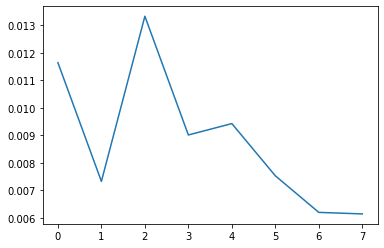

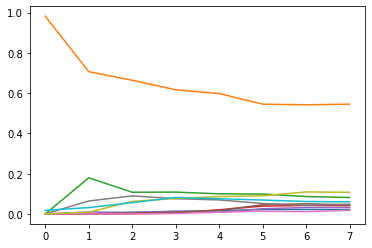

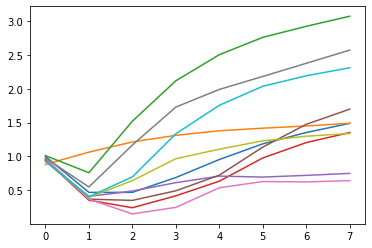

In [18]:
plt.plot(commitment_losses)
plt.show()
plt.plot(entropies)
plt.show()
plt.plot(codebook_norm)
plt.show()

In [48]:
# ckpt = tf.train.Checkpoint(**{'encoder': encoder, 'actor': actor, 'planner':planner, 'VQ':VQ})
# chkpt_manager = tf.train.CheckpointManager(ckpt, 'experimental/p', max_to_keep=1)
# save_path = ckpt.restore(tf.train.latest_checkpoint('experimental/p'))

In [42]:
from importlib import reload
# reload(lfp.experimental)

from lfp.experimental import conditional_transformer


planner_optimizer = tf.optimizers.Adam(learning_rate=args.learning_rate)
planner = conditional_transformer(args.codebook_size, max_len=(codebook_edges*codebook_edges)-1, goal_dim=10, embed_dim=args.latent_dim, num_heads=8, feed_forward_dim=512, num_layers=6)

def planner_step(batch):
    enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc, z_plan, labels, classes, quantised = step(batch)
    goal = classes[:,tf.newaxis,:]
    
    codes = tf.reshape(quantised['indices'], (args.batch_size, -1))
    out = planner((goal, codes[:,:-1]))
    logits = out['logits']
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=codes, logits=logits))
    
    decisions = tf.argmax(tf.nn.softmax(logits, -1), -1)
    accuracy = tf.reduce_mean(tf.cast(codes == decisions, tf.float32))
    return loss, logits, accuracy
    
def planner_train_step(batch):
    with tf.GradientTape() as planner_tape:
        loss, logits, accuracy = planner_step(batch)
        grads = planner_tape.gradient(loss, planner.trainable_variables)
        planner_optimizer.apply_gradients(zip(grads, planner.trainable_variables))
        
    return loss, logits, accuracy

In [43]:
train_plan_losses = []
test_plan_losses = []
train_plan_acc = []
test_plan_acc = []

t = [0]


In [44]:

for i in tqdm_notebook(range(0, 200000)):
    batch = train_dataset.next()
    train_loss, train_logits, train_accuracy = planner_train_step(batch)
    if i % 100 == 0:
        loss, logits, accuracy = planner_step(test_dataset.next())
        train_plan_losses.append(train_loss.numpy()), test_plan_losses.append(loss.numpy()), train_plan_acc.append(train_accuracy.numpy()), test_plan_acc.append(accuracy.numpy()), t.append(i)
        
        print(loss.numpy(), accuracy.numpy())
        
    if i % 10 == 0:
        ckpt = tf.train.Checkpoint(**{'encoder': encoder, 'actor': actor, 'planner':planner, 'VQ':VQ})
        chkpt_manager = tf.train.CheckpointManager(ckpt, 'experimental/p', max_to_keep=1)
        save_path = chkpt_manager.save()
        B

<ipython-input-44-efb5bef5c7a2>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, 200000)):


  0%|          | 0/200000 [00:00<?, ?it/s]

2.0641131 0.2265625


NameError: name 'B' is not defined

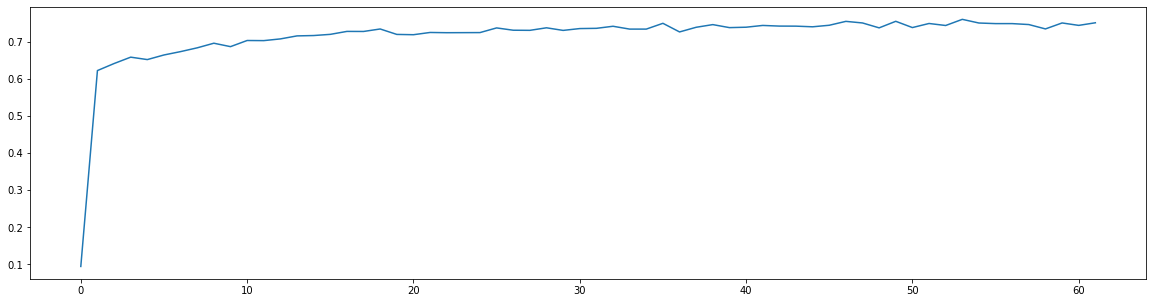

In [1137]:

plt.plot(test_plan_acc)

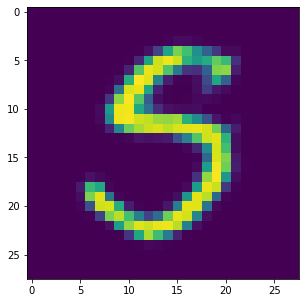

In [1224]:
idx = 0
enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc, z_plan, labels, classes, quantised = step(test_dataset.next())
plt.imshow(tf.reshape(enc_policy[idx], (img_edges,img_edges)))

In [1225]:
tf.reshape(quantised['indices'], (128,-1))

<tf.Tensor: shape=(128, 49), dtype=int64, numpy=
array([[2, 2, 0, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 9, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 9, ..., 2, 2, 2],
       [2, 2, 9, ..., 2, 2, 2]])>

In [1234]:
goal = classes[idx][tf.newaxis, tf.newaxis, :]

def sample_from(logits, k = 5):
    logits, indices = tf.math.top_k(logits, k=k, sorted=True)
    indices = np.asarray(indices).astype("int32")
    preds = tf.keras.activations.softmax(tf.expand_dims(logits, 0))[0]
    preds = np.asarray(preds).astype("float32")
    return np.random.choice(indices, p=preds)

sequence = []
logits = planner((goal, None))['logits']
ix = tf.argmax(tf.nn.softmax(logits, -1), -1).numpy()
sequence.append(ix[0][0])
for i in range(0,(codebook_edges*codebook_edges)-1):
    logits = planner((goal, tf.convert_to_tensor(sequence)[tf.newaxis]))['logits']
    sequence.append(sample_from(logits[0,-1,:]))

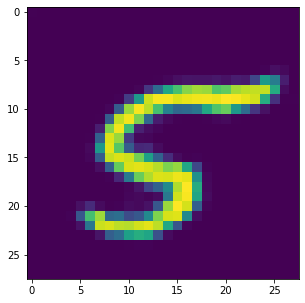

In [1235]:
er = actor(tf.reshape(VQ.quantise(tf.convert_to_tensor(sequence)), (codebook_edges,codebook_edges,-1))[tf.newaxis, :,:,:]).numpy().squeeze()
plt.imshow(er)

In [915]:
goal = classes[idx][tf.newaxis, tf.newaxis, :]


sequence = []
logits = planner((goal, None))['logits']
ix = tf.argmax(tf.nn.softmax(logits, -1), -1).numpy()
sequence.append(ix[0][0])
for i in range(0,(codebook_edges*codebook_edges)-1):
    logits = planner((goal, tf.convert_to_tensor(sequence)[tf.newaxis]))['logits']
    ix = tf.argmax(tf.nn.softmax(logits, -1), -1).numpy()
    sequence.append(ix[0][-1])

In [519]:
goal = 3




e1  = actor(tf.reshape(VQ.quantise(tf.reshape(example, -1)), (codebook_edges,codebook_edges,-1))[tf.newaxis, :,:,:]).numpy().squeeze()

InvalidArgumentError: Input to reshape is a tensor with 196 values, but the requested shape requires a multiple of 16 [Op:Reshape]

In [275]:

np.savez(os.getcwd()+'/notebooks/experiments/cnn16', t=t, train_enc_losses=train_enc_losses, train_plan_losses=train_plan_losses, test_enc_losses=test_enc_losses, test_plan_losses=test_plan_losses, train_reg_losses=train_reg_losses, test_reg_losses=test_reg_losses)

<ipython-input-267-e824857ab9ce>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 1)
<ipython-input-267-e824857ab9ce>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 2)
<ipython-input-267-e824857ab9ce>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created 

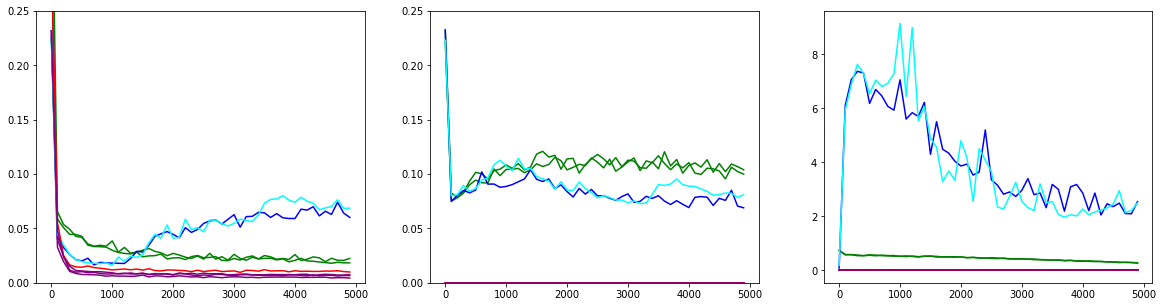

In [276]:

display('test',  'green', 'green' )
display('cnn',  'purple', 'purple' )
display('mlp_128_B0000001',  'blue', 'cyan' )
display('cnn16',  'r', 'purple' )

In [1248]:
def plot_orig_and_recon(orig, recon, recon_plan, idx):
    plt.subplot(1, 3, 1)
    plt.imshow(orig[idx])
    plt.subplot(1, 3, 2)
    plt.imshow(tf.reshape(recon[idx],(img_edges,img_edges)))
    plt.subplot(1, 3, 3)
    plt.imshow(tf.reshape(recon_plan[idx],(img_edges,img_edges)))

In [1249]:
b = test_dataset.next()

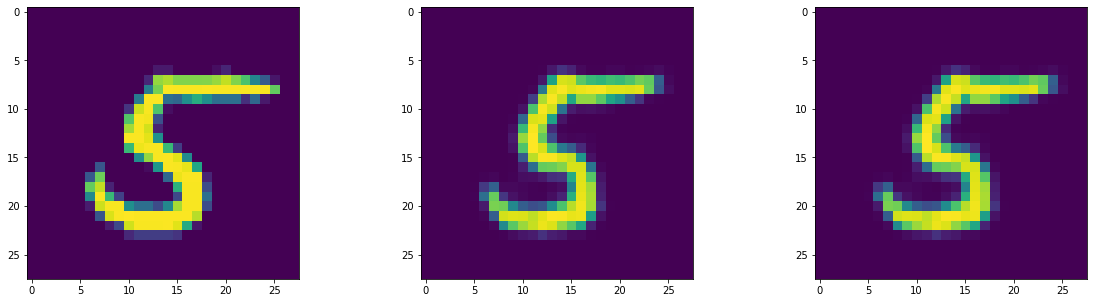

In [1250]:
enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc, z_plan, labels, classes, quantised = step(b)
plot_orig_and_recon(labels, enc_policy, plan_policy, 0)

Originals versus reconstructions


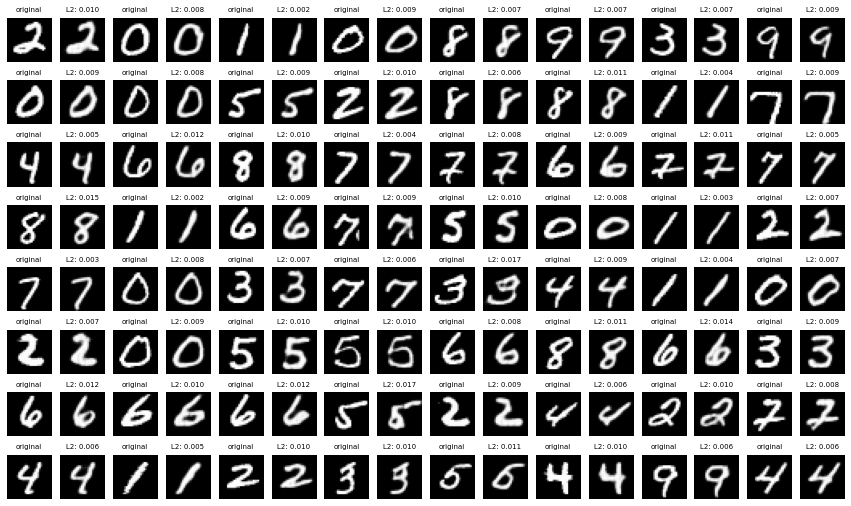

In [1251]:
# original versus reconstructions
def recons(n_row, n_col, random=True):
    n = n_row * n_col
    b = test_dataset.next()
    enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc, z_plan, labels, classes, quantised = step(b)
    enc_policy = tf.reshape(enc_policy, (-1, img_edges, img_edges))
    dists = np.mean((enc_policy - b['x'])**2, axis=(1, 2))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(b['x'][i, :, :], cmap='gray')
        plt.title("original", fontsize=7)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(enc_policy[i, :, :], cmap='gray')
        plt.title("L2: {:.3f}".format(dists[i]), fontsize=7)
        plt.axis('off')
    plt.show()
    
print("Originals versus reconstructions")
recons(8, 8)

(<matplotlib.image.AxesImage at 0x7fded6b5f8b0>,
 <tf.Tensor: shape=(7, 7), dtype=int64, numpy=
 array([[0, 0, 6, 2, 3, 0, 0],
        [0, 0, 2, 1, 2, 0, 0],
        [0, 0, 5, 1, 1, 0, 0],
        [0, 6, 5, 4, 3, 0, 0],
        [0, 5, 6, 3, 2, 0, 0],
        [0, 8, 5, 4, 4, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])>)

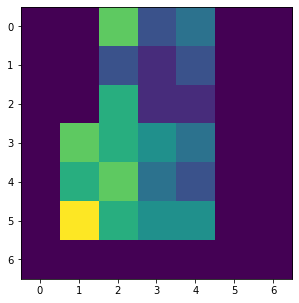

In [1052]:
plt.imshow(tf.reshape(quantised['indices'], (args.batch_size, codebook_edges,codebook_edges))[0]), tf.reshape(quantised['indices'], (args.batch_size, codebook_edges,codebook_edges))[0]

In [1053]:
VQ.codebook

<tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[ 0.19219677, -0.02866307, -0.17329282,  0.18398543,  0.02840999,
        -0.15024751, -0.10499977, -0.0733498 , -0.12364352, -0.17779809],
       [-0.06587107, -0.19490817,  0.180046  , -0.19309583, -0.11035913,
         0.01807718,  0.03697701,  0.10180806, -0.14898264,  0.02962185],
       [-0.15232828, -0.03899202, -0.11057423, -0.0422755 ,  0.05497949,
        -0.1890684 , -0.11741289,  0.17579107, -0.18295339, -0.0980315 ],
       [ 0.12653027, -0.18140239, -0.01716006,  0.06940858, -0.01321027,
         0.20563854,  0.14034449,  0.10347928,  0.07290299,  0.04928641],
       [ 0.15413515,  0.03641431,  0.00408818, -0.03056659, -0.10801779,
        -0.19694698, -0.16402574,  0.08599471, -0.09968254,  0.16150533],
       [ 0.14466561,  0.20454888, -0.11782858, -0.18938224,  0.04035579,
        -0.01208012,  0.01961306,  0.1325004 , -0.02128763, -0.05639236],
       [-0.1379076 , -0.06004137,  0.08417062, -0.10239884,  0.08066

In [1099]:
import tensorflow.keras as K

def gate(inputs):
    """Gated activations"""
    x, y = tf.split(inputs, 2, axis=-1)
    return Kb.tanh(x) * Kb.sigmoid(y)


class MaskedConv2D(K.layers.Layer):
    """Masked convolution"""
    def __init__(self, kernel_size, out_dim, direction, mode, **kwargs):
        self.direction = direction     # Horizontal or vertical
        self.mode = mode               # Mask type "a" or "b"
        self.kernel_size = kernel_size
        self.out_dim = out_dim
        super(MaskedConv2D, self).__init__(**kwargs)
    
    def build(self, input_shape):   
        filter_mid_y = self.kernel_size[0] // 2
        filter_mid_x = self.kernel_size[1] // 2        
        in_dim = int(input_shape[-1])
        w_shape = [self.kernel_size[0], self.kernel_size[1], in_dim, self.out_dim]
        mask_filter = np.ones(w_shape, dtype=np.float32)
        # Build the mask
        if self.direction == "h":
            mask_filter[filter_mid_y + 1:, :, :, :] = 0.
            mask_filter[filter_mid_y, filter_mid_x + 1:, :, :] = 0.
        elif self.direction == "v":
            if self.mode == 'a':
                mask_filter[filter_mid_y:, :, :, :] = 0.
            elif self.mode == 'b':
                mask_filter[filter_mid_y+1:, :, :, :] = 0.0
        if self.mode == 'a':
            mask_filter[filter_mid_y, filter_mid_x, :, :] = 0.0
        # Create convolution layer parameters with masked kernel
        self.W = mask_filter * self.add_weight("W_{}".format(self.direction), w_shape, trainable=True)
        self.b = self.add_weight("v_b", [self.out_dim,], trainable=True)
    
    def call(self, inputs):
        return K.backend.conv2d(inputs, self.W, strides=(1, 1)) + self.b

    
def gated_masked_conv2d(v_stack_in, h_stack_in, out_dim, kernel, mask='b', residual=True, i=0):
    """Basic Gated-PixelCNN block. 
       This is an improvement over PixelRNN to avoid "blind spots", i.e. pixels missingt from the
       field of view. It works by having two parallel stacks, for the vertical and horizontal direction, 
       each being masked  to only see the appropriate context pixels.
    """
    kernel_size = (kernel // 2 + 1, kernel)
    padding = (kernel // 2, kernel // 2)
        
    v_stack = K.layers.ZeroPadding2D(padding=padding, name="v_pad_{}".format(i))(v_stack_in)
    v_stack = MaskedConv2D(kernel_size, out_dim * 2, "v", mask, name="v_masked_conv_{}".format(i))(v_stack)
    v_stack = v_stack[:, :int(v_stack_in.get_shape()[-3]), :, :]
    v_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="v_gate_{}".format(i))(v_stack)
    
    kernel_size = (1, kernel // 2 + 1)
    padding = (0, kernel // 2)
    h_stack = K.layers.ZeroPadding2D(padding=padding, name="h_pad_{}".format(i))(h_stack_in)
    h_stack = MaskedConv2D(kernel_size, out_dim * 2, "h", mask, name="h_masked_conv_{}".format(i))(h_stack)
    h_stack = h_stack[:, :, :int(h_stack_in.get_shape()[-2]), :]
    h_stack_1 = K.layers.Conv2D(filters=out_dim * 2, kernel_size=1, strides=(1, 1), name="v_to_h_{}".format(i))(v_stack)
    h_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="h_gate_{}".format(i))(h_stack + h_stack_1)
    
    h_stack_out =  K.layers.Conv2D(filters=out_dim, kernel_size=1, strides=(1, 1), name="res_conv_{}".format(i))(h_stack_out)
    if residual:
        h_stack_out += h_stack_in
    return v_stack_out, h_stack_out

In [1100]:
x_train.shape

(60000, 28, 28)

In [1101]:
indices = [0, 20000, 40000, 60000]

zs = []
for x in range(0, len(indices)-1):
    
    zs.append(encoder(x_train[indices[x]:indices[x+1]]))
    
disc_train = tf.concat(zs, 0)

In [1102]:
z_train = tf.reshape(VQ.forward(disc_train)['indices'], (60000,7,7))

In [102]:
example = tf.reshape(quantised['indices'], (args.batch_size, 7,7))[0].numpy()
example[3,3] = 1
tf.convert_to_tensor(example)
e1  = actor(tf.reshape(VQ.quantise(tf.reshape(example, -1)), (7,7,-1))[tf.newaxis, :,:,:]).numpy().squeeze()

In [103]:
example = tf.reshape(quantised['indices'], (args.batch_size, 7,7))[0]
e2 = actor(tf.reshape(VQ.quantise(tf.reshape(example, -1)), (7,7,-1))[tf.newaxis, :,:,:]).numpy().squeeze()

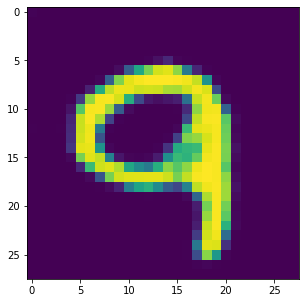

In [104]:
plt.imshow(e1)

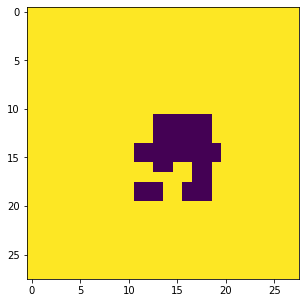

In [105]:
plt.imshow(e1 - e2 < 0.00001)

In [306]:

enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc, z_plan, labels, classes, quantised = step(plot_ds.next())
plot(z_enc, z_plan, classes)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [224]:
def discrete_step(batch):

    b, flattened, encoding = encode(batch) 
    

    encoding = tf.reshape(encoding, (-1, args.vq_tiles, args.latent_dim))
    encoding = VQ.forward(encoding) # B * args.vq_tiles, args.latent_dim
    z_enc = encoding['quantised']
#     z_enc = tf.reshape(z_enc, (-1, args.vq_tiles*args.latent_dim))
    
    enc_policy = actor(z_enc) # [B*v_tiles, latent dim]
    enc_policy = tf.reshape(enc_policy, (-1, 784))
    enc_loss = tf.reduce_mean((flattened-enc_policy)**2)
    
    z_plan = planner(b['goals'])
    z_plan = tf.reshape(z_plan, z_enc.shape)
    reg_loss = tf.reduce_mean((tf.stop_gradient(z_enc)-z_plan)**2)

    
    plan_policy = tf.reshape(actor(z_plan), (-1, 784))
        
    
    plan_loss = tf.reduce_mean((flattened-plan_policy)**2)
    
    
    return enc_loss, plan_loss, reg_loss, enc_policy, plan_policy, z_enc, z_plan, b['acts'], b['goals'], encoding


<tf.Tensor: shape=(8192, 4), dtype=float32, numpy=
array([[-0.42362565,  0.34858647, -0.22641942, -0.04112525],
       [-0.6443493 , -0.17307267, -0.6137195 , -0.27133682],
       [-0.20463228,  0.56149846,  0.14828573,  0.3745491 ],
       ...,
       [-0.22910376,  0.37735003,  0.17192908, -0.16519634],
       [-0.42362565,  0.34858647, -0.22641942, -0.04112525],
       [-0.40630877,  0.4794091 ,  0.2902233 , -0.19485612]],
      dtype=float32)>

In [47]:
batch  = train_dataset.next()

In [9]:
actor, encoder, planner, cnn, gripper_cnn,  img_embed_to_goal_space, lang_embed_to_goal_space, trainer =lfp.train.train_setup(args, dl, GLOBAL_BATCH_SIZE, strategy=None)

In [10]:
img_embed_to_goal_space.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lang_embeds (InputLayer)     [(None, 64)]              0         
_________________________________________________________________
masking_3 (Masking)          (None, 64)                0         
_________________________________________________________________
layer_1 (Dense)              (None, 512)               33280     
_________________________________________________________________
layer_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
goal_space (Dense)           (None, 32)                16416     
Total params: 312,352
Trainable params: 312,352
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trainer.load_weights(path, from_checkpoint=True)

In [ ]:
batch = v_it.next()
batch = trainer.make_sequences_variable_length(batch)

In [ ]:
for k,v in batch.items():
    print(k, v.shape)

In [ ]:
print(f'Obs: (N,{dl.obs_dim}), Acts: (N,{dl.act_dim}), Goals: (N,{dl.goal_dim})')

In [14]:
enc_policy, plan_policy, encoding, plan, indices, actions, masks, seq_lens, sentence_embeddings = trainer.step(batch)

In [15]:
enc_policy.sample()

<tf.Tensor: shape=(2, 40, 7), dtype=float32, numpy=
array([[[-2.09350094e-01,  2.96971798e-01,  1.26349807e-01,
          5.95697105e-01, -4.70449179e-01,  8.51688087e-01,
          9.99577940e-01],
        [-2.13931352e-01,  3.10606837e-01,  1.24338180e-01,
          5.81577063e-01, -4.64834154e-01,  8.55745852e-01,
          9.99502242e-01],
        [-2.09207982e-01,  3.22105795e-01,  1.20666109e-01,
          6.02780223e-01, -4.66054916e-01,  8.63247216e-01,
          1.00095344e+00],
        [-1.98105037e-01,  3.37985843e-01,  1.14595741e-01,
          6.09973907e-01, -4.34885442e-01,  8.51228833e-01,
          1.00102746e+00],
        [-1.73984423e-01,  3.50872040e-01,  1.07711233e-01,
          6.04590595e-01, -4.31720227e-01,  7.99286366e-01,
          1.00029695e+00],
        [-1.55172780e-01,  3.56448710e-01,  1.04052864e-01,
          5.55852771e-01, -4.30466503e-01,  8.03194106e-01,
          1.00071073e+00],
        [-1.12775952e-01,  3.60404968e-01,  9.82027650e-02,
      

/home/sholto/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sholto/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sholto/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

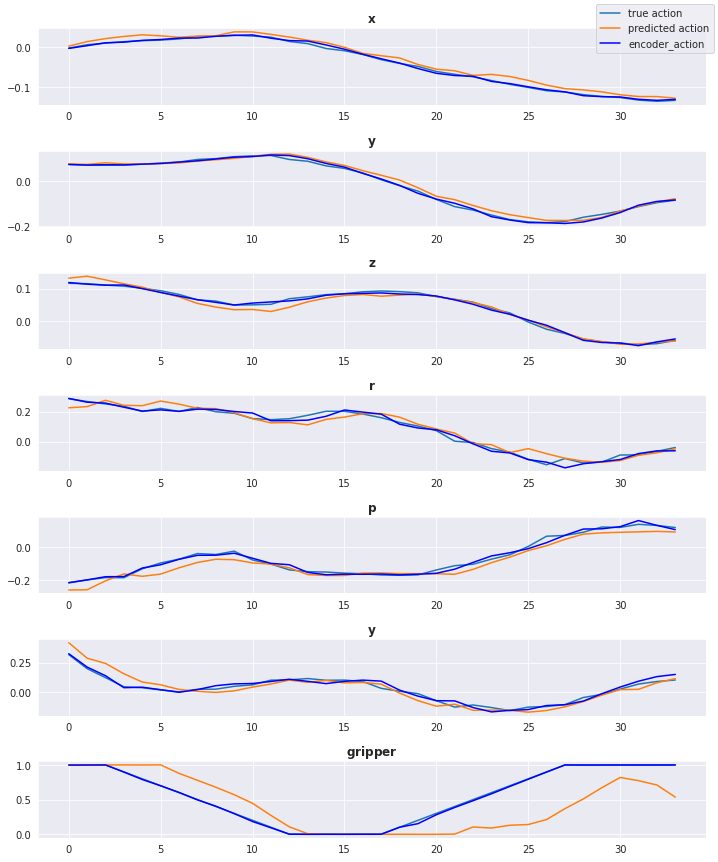

In [16]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
import seaborn as sns
sns.set_style("darkgrid")

idx = 1
seq_len = tf.cast(batch['seq_lens'][idx], tf.int32)
x = np.arange(seq_len)
labels = ['x','y','z','r','p','y','gripper']
fig, axes = plt.subplots(dl.act_dim, 1, figsize=(10,12), squeeze=True)
for i in range(dl.act_dim):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(batch['acts'][idx,:seq_len,i])
    axes[i].plot(plan_policy[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not args.gcbc:
      sns.lineplot(x, enc_policy[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()

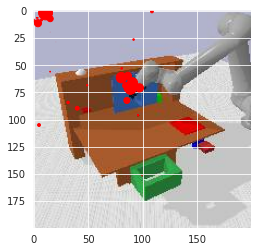

In [17]:
from IPython.display import display, clear_output
batch = v_it.next()
batch = trainer.make_sequences_variable_length(batch)

def plot_keypoints(cnn, imgs, seq_len):
    for i in range(0, seq_len):

        sh = imgs[i]
        plt.imshow(sh)
        keypoints = tf.squeeze(cnn(sh[tf.newaxis,:])[1])*sh.shape[1]
        plt.scatter(keypoints[:,1], keypoints[:,2], s=keypoints[:,0], c='r')
        plt.show()
        clear_output(wait=True)
        
for i in range(0,1):
    batch = v_it.next()
    batch = trainer.make_sequences_variable_length(batch)
    plot_keypoints(cnn, batch['imgs'][0], int(batch['seq_lens'][0]))

In [18]:
from importlib import reload
reload(lfp)
reload(lfp.data)
labelled_dl = lfp.data.labelled_dl(batch_size=50, include_images = args.images, include_images2 = args.images2, include_gripper_images=args.gripper_images, sim = args.sim, shuffle_size=32)
labelled_ds = iter(labelled_dl.load(labelled_dl.extract(TEST_DATA_PATHS)))
big_lang_batch = labelled_ds.next()

In [19]:
batches = [trainer.make_sequences_variable_length(v_it.next()) for i in range(0,80)]
super_batch = {}
for k in batch.keys():
    super_batch[k] = np.concatenate([b[k] for b in batches])
super_batch['obs'].shape

(160, 40, 18)

In [20]:
from importlib import reload
reload(lfp)
reload(lfp.plotting)

<module 'lfp.plotting' from '/home/sholto/Desktop/robotics/learning_from_play/lfp/plotting.py'>

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]
/home/sholto/anaconda3/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
/home/sholto/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


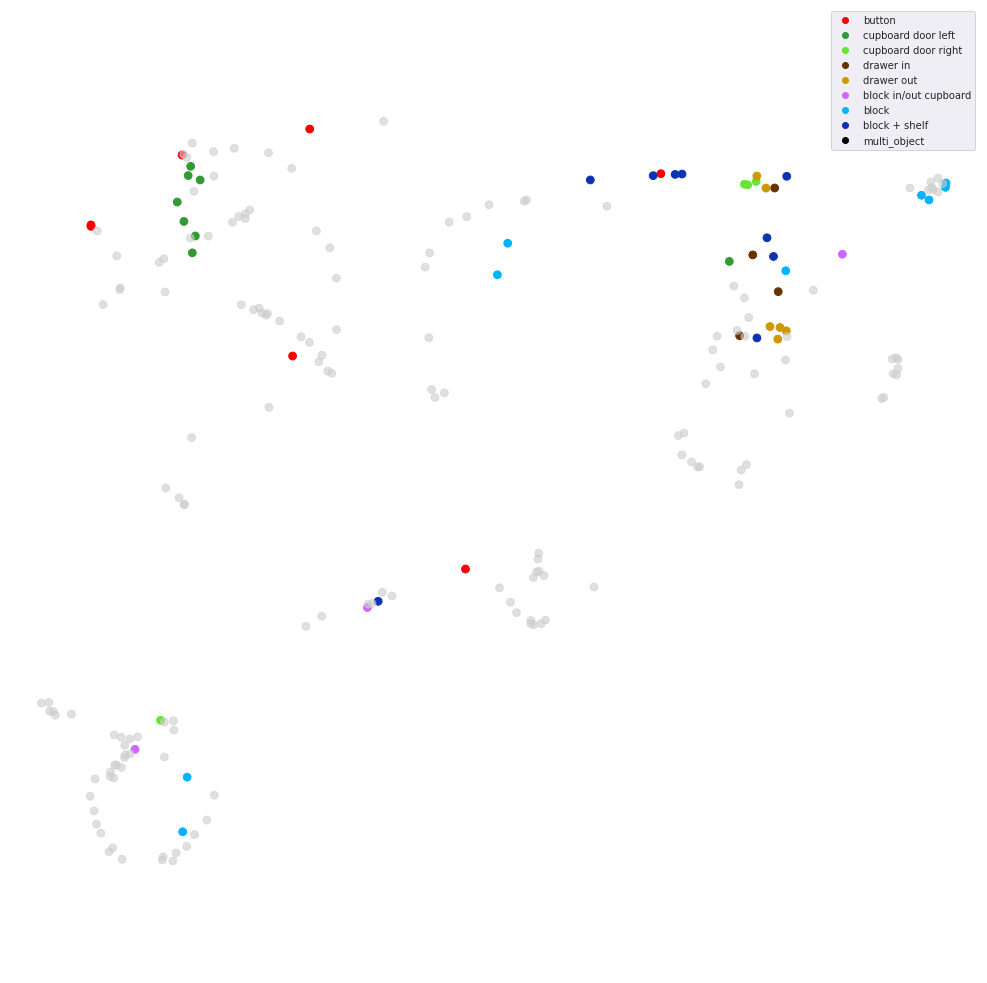

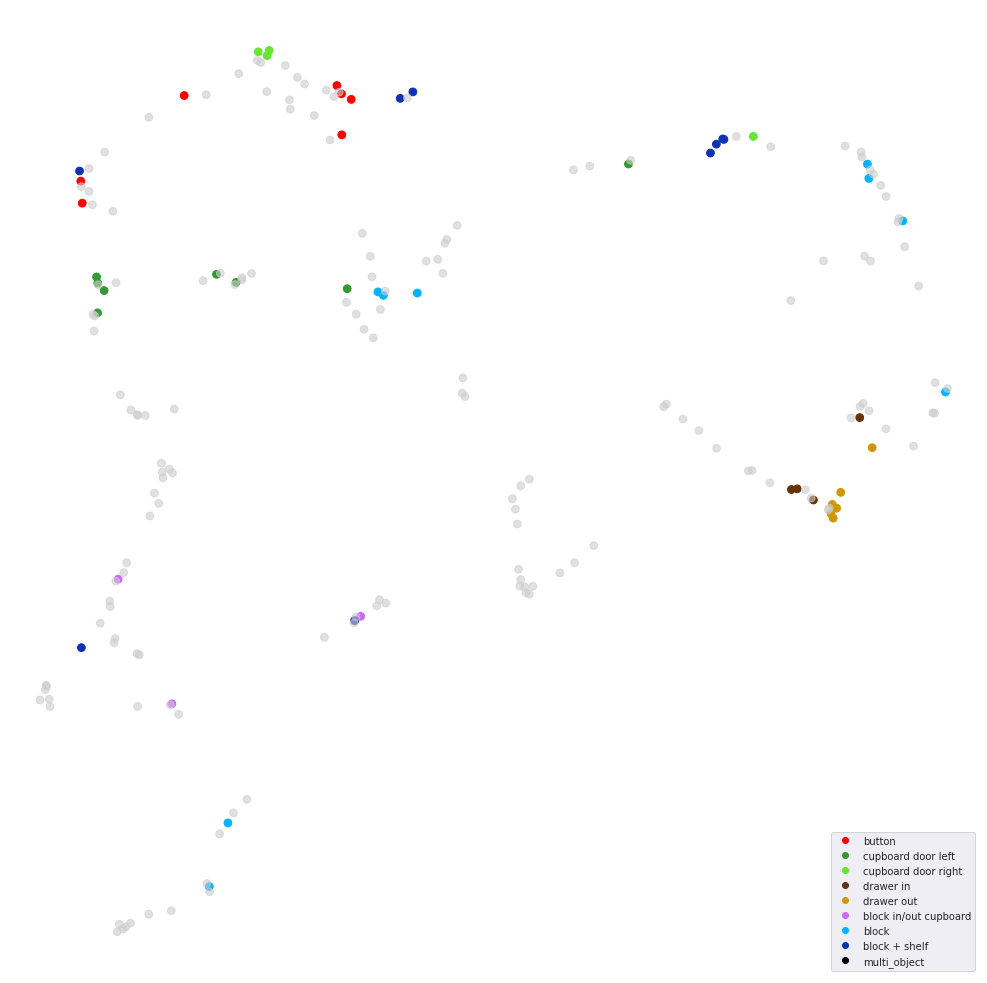

In [21]:
from lfp.plotting import produce_cluster_fig
%matplotlib inline
fig_enc, fig_plan, z_enc, z_plan = produce_cluster_fig(super_batch, big_lang_batch, trainer, args=args)

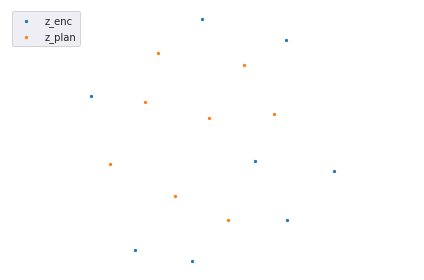

In [22]:
from lfp.plotting import project_enc_and_plan

o = project_enc_and_plan(z_enc, z_plan, connecting_lines=False)

In [21]:
# env.instance.close()
import roboticsPlayroomPybullet

In [22]:
# import importlib
# del gym.registry.env_specs[<env-id>]
# importlib.reload(roboticsPlayroomPybullet)

In [23]:

import time
import seaborn as sns


env = lfp.utils.load_env(JOINTS = dl.joints, QUAT = dl.quaternion_act, RELATIVE = dl.relative_act)
env.render('human')
env.reset()
if args.images:
    env.render('playback')

current_dir=/home/sholto/Desktop/AI/RoboticsPlayroomPybullet/roboticsPlayroomPybullet/envs
current_dir=/home/sholto/Desktop/AI/RoboticsPlayroomPybullet/roboticsPlayroomPybullet/envs
current_dir=/home/sholto/Desktop/AI/RoboticsPlayroomPybullet/roboticsPlayroomPybullet/envs


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN',

/home/sholto/Desktop/AI/RoboticsPlayroomPybullet/roboticsPlayroomPybullet/envs


In [24]:


model_params = {'obs_dim':args.img_embedding_size + dl.proprioceptive_features_dim if args.images else dl.obs_dim,
            'goal_dim':args.img_embedding_size if args.images else dl.goal_dim,
            'act_dim':dl.act_dim,
            'layer_size':args.actor_layer_size, 
            'latent_dim':args.latent_dim,
            'training':False, 'return_state':True}

actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)

lfp.utils.load_weights(path, actor, encoder, planner, cnn)

Checkpoint restored


In [25]:
lfp.utils.load_weights(path, actor, encoder, planner, cnn)

Checkpoint restored


# Test against specified goals

In [26]:
def flatten_obs(obs_dict, record_o_buff=None):
    '''
    Get the right format and flatten, e.g get joints states, velcoities, rpy or quat etc depending on what the
    net was trained on
    Also appends it to record_o_buff to record the true obs
    '''

    o = obs_dict['observation']
    
    if args.images:
        proprioceptive_features = tf.cast(tf.expand_dims(o[:7],0), tf.float32)
        img = obs_dict['img']
        img_embedding = cnn(tf.expand_dims(img, 0))
        o = tf.squeeze(tf.concat([img_embedding, proprioceptive_features],axis=1))
        
    if dl.joints:
        o = tf.expand_dims(tf.expand_dims(np.concatenate([o, obs_dict['joints'][:7]]),0),0)
    else:
        o = tf.expand_dims(tf.expand_dims(o,0),0)
        
    if dl.gripper_proprioception:
         o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast([obs_dict['gripper_gripper_proprioception']],tf.float32),0),0)], axis = -1)
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    if record_o_buff is not None:
        record_o_buff.append(o)
    return o


def choose_action(actor, o, z, goal, states=None, a_pred=None, a_true=None, replay=False, i = -0):
    if args.gcbc:
        a,_,state = actor((o, goal))
    else:
        a,_,state = actor((o, z,goal))
        
    if args.num_distribs is not None:
        a = a.sample().numpy().squeeze()
    else:
        a = a.numpy().squeeze()
    if states is not None:
        states.append(state)
    if a_pred is not None:
        a_pred.append(a)

    if replay: # the less than is just so we can set it so the first n are from demonstration- to check if the init is the issue
        a=a_true[i, :] 
    return a

def rollout_subseq(goal,retries=1, replan_horizon=30, a_true=None, o_true=None, traj_len=None, replay=False,end_on_success = False, record_dir=None, reset_goal=True):
    
    a_pred = []
    states = []
    record_o_buff = []
    plans = [] 
    
    state = env.instance.calc_state()
    o = flatten_obs(state, record_o_buff)
    
    success = 0 
    
    for j in range(0,retries):
        
        
        
        if isinstance(goal, dict):
            # a function which remakes the goal so pertubations of other objects don't matter, letting us specify only what we want different from the rest of the env at the time we took the goal
            if j<=1 or reset_goal: # if its the first/two (solves some weird shit in the env with the button bouncing around after reset) time or we reset the goal to ignore pertubations of other objects
                g = goal['func'](*goal['args'])
                env.visualise_sub_goal(np.squeeze(g), 'achieved_goal')
        else:
            g = goal
        
        if args.gcbc:
            z = None
        else:
            plan = planner((o[0], g[0]))
            z = tf.expand_dims(plan.sample(),0)
            plans.append(z.numpy())
        actor.reset_states()
        
        if replay:
            replan_horizon = traj_len
            
        
        for i in range(0, replan_horizon):
            a = choose_action(actor, o, z, g, states, a_pred, a_true, replay, i)
            o, r, d, _ = env.step(a)
            
            # put the o here
            ag = o['achieved_goal']
            if record_dir is not None:
                record_state(record_dir)
            
            o = flatten_obs(o, record_o_buff)
            if not args.images:
                if success_func(g, ag):
                    success = 1
                
        if end_on_success and success:
            return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans, success
            
        
            
    return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans,  success

In [35]:
from lfp.tests import tester, tasks, success_func, tests

tester = tester(env)

kwargs = {'goal':{'func':tester.make_goal, 'args':None}, 'retries':20, 'replan_horizon':10, 'end_on_success':True, 'record_dir': None, 'reset_goal':False}

In [36]:


task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_lengthways_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
_ = env.reset()
for i, task in enumerate(task_list):
    kwargs['goal']['args'] = tasks[task]
    _,_,_,_,_,_,succeeded  = rollout_subseq(**kwargs)

ValueError: Input 1 is incompatible with layer model_2: expected shape=(None, 64), found shape=(1, 11)

<module 'lfp.tests' from '/home/sholto/Desktop/AI/learning_from_play/lfp/tests.py'>

# Test against labelled trajectories from the test data examples

In [35]:
import time

from lfp.plotting import get_labelled_trajs
##############################################################################
def get_x_of_seq_type(lbl, n = 'all'):
    o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features = get_labelled_trajs(TEST_DATA_PATHS[0], args=args)
    idxs = [ i for i,x in enumerate(labels) if x == lbl]
    print(f"There are {len(idxs)} examples of '{lbl}'")
    if n == 'all':
        return o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, idxs
    elif n == 'random':
        idx = np.random.choice(idxs)
        return o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, [idx]
    else:
        idx = idxs[n]
        return o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, [idx]

def initialise_seq_type(g, paths, idx):

    try:
        env.delete_sub_goal()
    except:
        pass
    print(paths[idx])
    env.p.restoreState(fileName=str(paths[idx]))
    if args.images:
        plt.imshow(g[idx])
        plt.show()
        goal  =  tf.expand_dims(cnn(tf.expand_dims(g[idx], 0)),0)
    else:
        env.visualise_sub_goal(g[idx], 'achieved_goal') # if we're using images, don't viz the goal as this will change things
        goal = tf.expand_dims(tf.expand_dims(g[idx], 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    

    return goal

def test_seq_type(data, retries = 1, replay=False, replan_horizon=30):
    o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, idxs = data
    successes = []
    for idx in idxs:
        if args.images:
            g = goal_imgs
            
        goal = initialise_seq_type(g, paths, idx)
        a_true, o_true, traj_len = a[idx], o[idx], len(a[idx])
        a_true, a_pred, states, o_true, record_o_buff, plans, success = rollout_subseq(goal, retries, replan_horizon, a_true, o_true, traj_len,replay)
        successes.append(success)
        
    return successes 




#########################################


In [38]:
lbl = 'door right'
data = get_x_of_seq_type(lbl, n = 'all') # all, random or n

There are 15 examples of 'door right'


# Replay examples with the expert actions

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/0.bullet


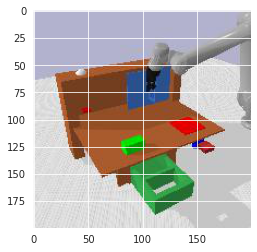

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3090.bullet


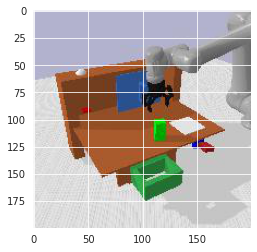

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/7170.bullet


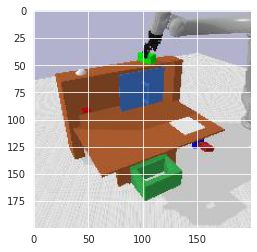

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/4440.bullet


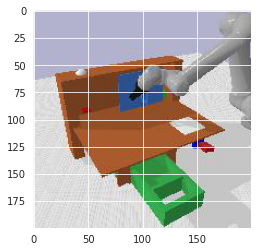

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3570.bullet


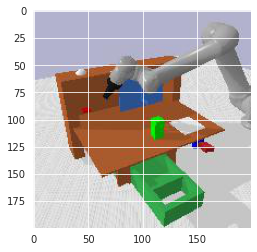

KeyboardInterrupt: 

In [39]:
successes = test_seq_type(data, retries = 1, replay=True, replan_horizon=30)

# Attempt the same trajectories

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/0.bullet


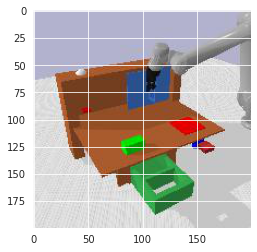

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3090.bullet


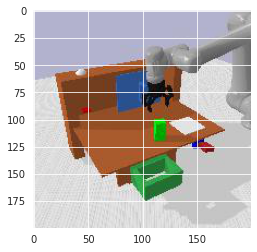

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/7170.bullet


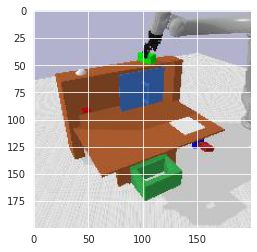

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/4440.bullet


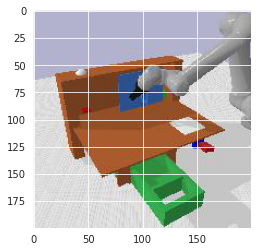

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3570.bullet


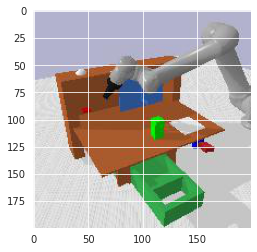

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/5880.bullet


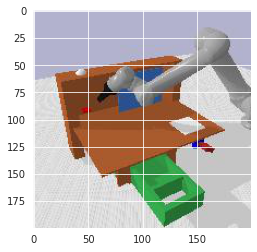

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/4740.bullet


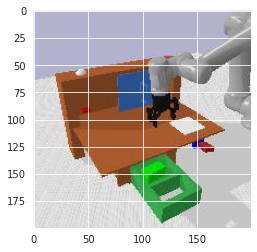

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/6060.bullet


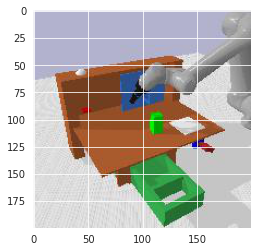

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/7980.bullet


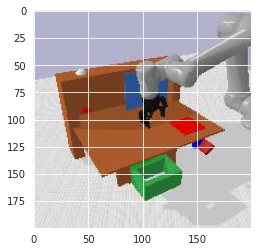

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/6870.bullet


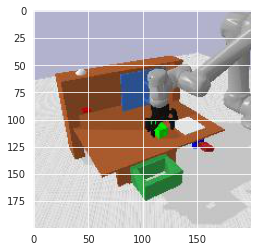

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/930.bullet


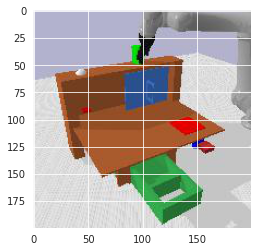

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/210.bullet


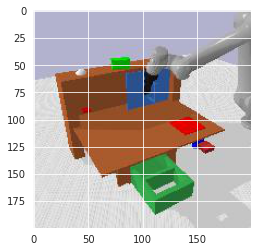

KeyboardInterrupt: 

In [41]:
successes = test_seq_type(data, retries = 10, replay=False, replan_horizon=20)

# Make recordings, and replay them while visualising the plans chosen

In [40]:
record_path = os.getcwd() + '/recordings/'

def make_recording_dir():
    demo_count = len(list(os.listdir(record_path)))
    example_path = record_path + str(demo_count)
    os.makedirs(example_path)
    return example_path


def record_state(path):
    t_step = len(list(os.listdir(path)))
    env.p.saveBullet(path +'/'+ str(t_step)) 

In [25]:

#env.render('playback') # 10 is good

In [73]:
import shutil
record_path = os.getcwd() + '/recordings/'

while len(list(os.listdir(record_path))) < 50:
    _ = env.reset()
    task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
    #task_list = [ 'block_upright']
    predicted_actions = []
    path = make_recording_dir()
    successes = 0
    for i, task in enumerate(task_list):
        kwargs['goal']['args'] = tasks[task]
        kwargs['record_dir'] = path
        _,a_pred,_,_,_,succeeded  = rollout_subseq(**kwargs)
        predicted_actions.append(a_pred)
        if succeeded:
            successes += succeeded
        else:
            break

    try:
        np.save(path + '/successes', successes)
        np.save(path + '/predicted_actions', np.vstack(predicted_actions))
        print(successes)
        if successes <= 10:
            shutil.rmtree(path)
    except:
        pass
    


8
4
11
5
4
11
11
11
6
4
6
2
7
4
9
11
2
6
2
6
11
11
12
12
10
5
11
7
4
7
8
6
4
11
5
12
12
11
7
6
11
9
11
11
6
12
9
4
6
6
4
4
6
6
0
7
0
11
11
11
3
2
8
11
7
11
12
4
11


KeyboardInterrupt: 

In [63]:

v_it = iter(valid_dataset)


# Replay and visualise plan space

In [16]:
importlib.reload(lfp)

<module 'lfp' from '/home/sholto/Desktop/AI/learning_from_play/lfp/__init__.py'>

In [42]:
import umap
reducer = umap.UMAP(metric='cosine', random_state=42)
from lfp.plotting import bucket_colors, get_labelled_trajs, hold_out, get_latent_vectors, project_labelled_latents
def establish_background(path, batch,encoder,planner,TEST_DATA_PATH, num_take, args, cnn=None, bucket=True, for_live_plotting=True):
    
    z_enc, z_plan, colors, batch_colors = get_latent_vectors(batch,encoder,planner,TEST_DATA_PATH, num_take, args, cnn, bucket)
   
    
    sampled_plans = np.load(path+'/sampled_plans.npy')
    z_space = np.concatenate([z_enc, z_plan, sampled_plans])
    reducer.fit(np.concatenate([z_enc, z_plan]))
    
    # Both the grey background dots and the labelled colored ones
    combined_colors = colors+batch_colors
    
    z_embed = reducer.transform(z_space)
    planner_embeddings = z_embed[len(z_enc):len(z_enc)+len(z_plan)] # embeddings of both the grey and colored labelled
    labelled_embeddings = z_embed[len(z_enc):len(z_enc)+len(colors)] # just the colored planner ones
    trajectory_plans = z_embed[len(z_enc)+len(z_plan):] # the ones from the trajectory we are replaying
    
    fig,scatter, ax = project_labelled_latents(planner_embeddings, combined_colors, bucket=True, figsize=(12,9)) # fig size 12,9
    
    return fig, ax, labelled_embeddings, colors, trajectory_plans

from scipy.spatial import KDTree

def plot_plan(i, labelled_embeddings, labelled_colors, trajectory_plans, past_point=None):
    plan = trajectory_plans[int(i//replan_interval)]
    tree = KDTree(labelled_embeddings)
    dd, ii = tree.query(plan, k=1) # get the nns
    spot_color = np.array(labelled_colors)[ii]# np.mean(np.array(label_colors)[ii], axis=0)
    if pp is not None:
        pp.remove()
    scatter = ax.scatter([plan[0]], [plan[1]], s=400, color = spot_color)
    plt.pause(0.01)
    
    return scatter

/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


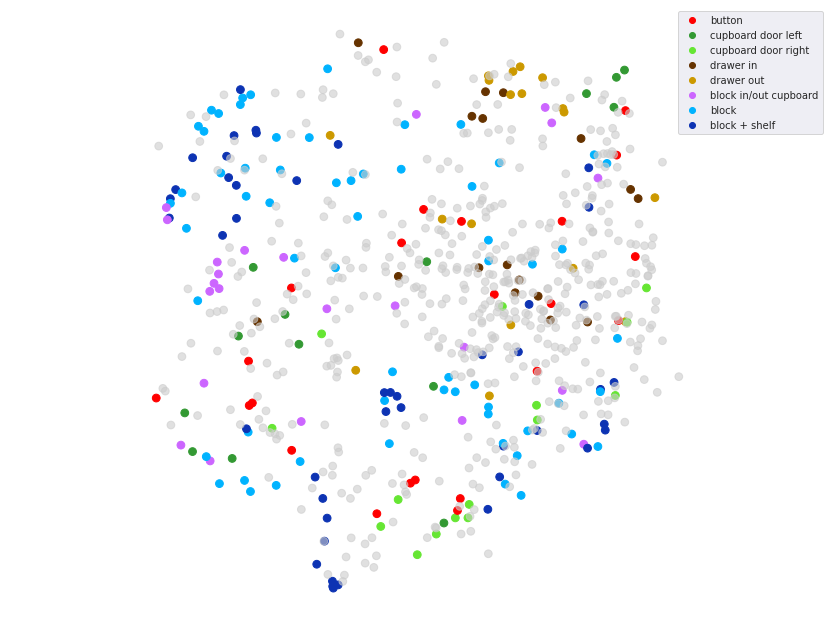

In [43]:
# This is replaying to visualise the plot 
%matplotlib qt
batch = v_it.next()
path = '/home/sholto/Desktop/AI/learning_from_play/recordings//13'
fig, ax, labelled_embeddings, labelled_colors, trajectory_plans = establish_background(path,batch, encoder, planner, TEST_DATA_PATHS[0], for_live_plotting=True, num_take=dl.batch_size, args=args, cnn=cnn)
pp = None

In [45]:

states = natsorted(list(os.listdir(path)))
states = [path+'/'+x for x in states if 'npy' not in x]
acts = np.load(path+'/predicted_actions.npy')
intervals = np.load(path+'/indices.npy')
replan_interval = len(states)/len(trajectory_plans)


time.sleep(1.0)
for i,s in enumerate(states):
        if i % replan_interval == 0:
             pp = plot_plan(i, labelled_embeddings, labelled_colors, trajectory_plans, past_point=pp)
        env.p.restoreState(fileName = s)
        env.step(acts[i])
        
        
        env.instance.updateToggles()

KeyboardInterrupt: 

In [67]:
def replay_recording(path):
    states = natsorted(list(os.listdir(path)))
    states = [path+'/'+x for x in states if 'npy' not in x]
    acts = np.load(path+'/predicted_actions.npy')
    intervals = np.load(path+'/indices.npy')
    for i,s in enumerate(states):
#         if int(i.split('/')[-1]) > 100:
#             print(i.split('/')[-1])
            env.step(acts[i])
            env.p.restoreState(fileName = s)
            env.instance.updateToggles()
            
            


In [108]:
path = '/home/sholto/Desktop/AI/learning_from_play/recordings//2'


(61, 256)

In [103]:

replay_recording('/home/sholto/Desktop/AI/learning_from_play/recordings//2')


# Success rate 

In [ ]:
test_results = []


In [ ]:
from lfp.configs_to_test import B0003, B00003,B000003, PB02
import pandas as pd
test_names = ['dial_off']
 
    
test_names = ['door_left','button','door_right','open_drawer','close_drawer','dial_off',\
              'block_cupboard_right','block_cupboard_left','block_left',\
              'block_right','block_shelf','block_drawer',\
            'block_lengthways', 'block_ori_default','block_upright'] 
 
 
configs_to_test = [PB02, B000003]

for config in configs_to_test:
    
    args = parser.parse_args(config)
    path = f"saved_models/{args.run_name}"    
    model_params = {'obs_dim':args.img_embedding_size + dl.proprioceptive_features_dim if args.images else dl.obs_dim,
            'goal_dim':args.img_embedding_size if args.images else dl.goal_dim,
            'act_dim':dl.act_dim,
            'layer_size':args.actor_layer_size, 
            'latent_dim':args.latent_dim,
            'training':False, 'return_state':True}

    actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)
    lfp.utils.load_weights(path, actor, encoder, planner, cnn)
    print(f"Loaded {args.run_name}")
    
    run_results = {'name': "R"+args.run_name}
    for i, test in enumerate(test_names):
        successes = []
        for j in range(0,30):
            _ = env.reset()
            tester.prepare_env(test)
            kwargs['goal']['args'] = tests[test]
            _,_,_,_,_,_,succeeded  = rollout_subseq(**kwargs)
            successes.append(succeeded)
        print(f"{test} success rate -  {np.mean(successes)}")
        run_results[test] = np.mean(successes)
    test_results.append(run_results)
        

Checkpoint restored
Loaded PROB0_02
door_left success rate -  0.9333333333333333
button success rate -  0.9
door_right success rate -  0.9333333333333333
open_drawer success rate -  0.9666666666666667
close_drawer success rate -  0.9333333333333333
dial_off success rate -  1.0
block_cupboard_right success rate -  0.7
block_cupboard_left success rate -  0.5
block_left success rate -  0.8
block_right success rate -  0.7666666666666667
block_shelf success rate -  0.9666666666666667
block_drawer success rate -  0.3333333333333333


In [ ]:
# pd.DataFrame(test_results).to_pickle(os.getcwd()+'/experimental/Test_logs2.pkl')
# #env.arm.close()
# pd.DataFrame(test_results)

# Adversarial blocks

In [48]:
def random_point():
    x = np.random.choice([0.5, -0.5])
    y =  np.random.choice([0.5, -0.5])
    z =  np.random.choice([0.3, 0.5, 0.6])
    return [x, y, z]
def create_adversary():
    
    side = 0.03
    colcubeId = bullet_client.createCollisionShape(bullet_client.GEOM_BOX, halfExtents=[side, side, side])
    visplaneId = bullet_client.createVisualShape(bullet_client.GEOM_BOX, halfExtents=[side, side, side],
                                                 rgbaColor=[1, 1, 1, 1])
    
    block = bullet_client.createMultiBody(0.1, colcubeId, visplaneId,random_point())
    return block

def guide_adversary(block):
    x1 = np.array(bullet_client.getBasePositionAndOrientation(block)[0])
    x2 = np.array(env.instance.calc_state()['observation'][0:3])
    bullet_client.applyExternalForce(block, -1, (x2-x1)*100, [0,0,0], bullet_client.LINK_FRAME)
    #bullet_client.stepSimulation()
    
bullet_client = env.p
adversaries = []
def rollout_subseq(goal,retries=1, replan_horizon=30, a_true=None, o_true=None, traj_len=None, replay=False,end_on_success = False, record_dir=None, reset_goal=False):
    
    a_pred = []
    states = []
    record_o_buff = []
    plans = [] 
    
    state = env.instance.calc_state()
    o = flatten_obs(state, record_o_buff)
    
    success = 0 
    for b in adversaries:
        bullet_client.removeBody(b)
    for j in range(0,retries):
        
        
        
        if isinstance(goal, dict):
            # a function which remakes the goal so pertubations of other objects don't matter
            g = goal['func'](*goal['args'])
            env.visualise_sub_goal(np.squeeze(g), 'achieved_goal')
        else:
            g = goal
        
        if args.gcbc:
            z = None
        else:
            plan = planner((o[0], g[0]))
            z = tf.expand_dims(plan.sample(),0)
            plans.append(z.numpy())
        actor.reset_states()
        
        if replay:
            replan_horizon = traj_len
            
        
        block = create_adversary()
        adversaries.append(block)
        
        for i in range(0, replan_horizon):
            a = choose_action(actor, o, z, g, states, a_pred, a_true, replay, i)
            o, r, d, _ = env.step(a)
            
            guide_adversary(block)
            # put the o here
            ag = o['achieved_goal']
            if record_dir is not None:
                record_state(record_dir)
            
            o = flatten_obs(o, record_o_buff)
            if success_func(g, ag):
                success = 1
                
        if end_on_success and success:
            return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans, success
            
        
            
    return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans,  success

In [49]:

task_list  = ['block_shelf']
_ = env.reset()
for i, task in enumerate(task_list):
    kwargs['goal']['args'] = tasks[task]
    _,_,_,_,_,_,succeeded  = rollout_subseq(**kwargs)

KeyboardInterrupt: 

# Functions to test random validation set indices

In [25]:


def get_closest_idx(point, idxs):
    
    
    closest_idx = idxs[0]
    best_diff = max(idxs)
    for i in idxs:
        diff = abs(point - i)
        if diff < best_diff:
            closest_idx = i
            best_diff = diff
    return closest_idx

def get_closest_init_state(f, start_index):
    
    potential_start_points = glob.glob(str(TEST_DIR/'states_and_ims'/str(f)/'env_states/*.bullet'))
    print(potential_start_points)
    if config.OS == 'windows':
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATHS[0])}/states_and_ims/{str(f)}/env_states\\", "")) for x in potential_start_points]
    else:
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATHS[0])}/states_and_ims/{str(f)}/env_states/", "")) for x in potential_start_points]
        
    closest_start = get_closest_idx(int(start_index), potential_start_idxs)
    return closest_start, f"{str(TEST_DATA_PATH)}/states_and_ims/{str(f)}/env_states/{closest_start}.bullet"

def get_expert_actions(data, closest_start, traj_len):
    if JOINTS:
        if RELATIVE:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:6] - data['joint_poses'][closest_start:closest_start+traj_len,:6],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis=1)
        else:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)],axis = 1)
    else:
        if QUAT:
            if RELATIVE:
                a_true = np.concatenate([data['acts'][closest_start:closest_start+traj_len,:7] - data['obs'][closest_start:closest_start+traj_len,:7], 
                                         np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis = 1)
            else:
                a_true = data['acts_quat'] 
        else:
            if RELATIVE:
                a_true = data['acts_rpy_rel'][closest_start:closest_start+traj_len,:]
            else:
                a_true = data['acts'][closest_start:closest_start+traj_len,:]
    return a_true
    
    
                
def get_true_obs(data, closest_start, traj_len):
    ''' gets the actual obs so we can test the encoder actions with them '''
    traj_len += 1 # because we need all the obs, which includes one more ob than there are actions (as that ob will be produced by the final action occuring)
    if USE_QUAT_OBS:
        o = data['obs_quat'][closest_start:closest_start+traj_len,:]
    else:
        o = data['obs'][closest_start:closest_start+traj_len,:]
    if JOINTS:
        o = np.concatenate([o, data['joints'][closest_start:closest_start+traj_len,:7]])
    
    o = tf.expand_dims(o,0)
        
    if VELOCITY:
        raise NotImplemented
    
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    return o
    
                


def initialise_subsequence(data):
    states, acts, goals, seq_lens, masks, pth, tsteps,_,_ = [data[k] for k in data.keys()]
    start_idx = str(int(tsteps[idx,0]))
    traj_len = len(np.where(masks[idx] == 1)[0])-1
    f = int(pth[idx,0])
    
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    #print(PYBULLET_TEST_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    closest_start, start_path = get_closest_init_state(f, start_idx)
    print(start_path)
    try:
        env.delete_sub_goal()
    except:
        pass
    env.p.restoreState(fileName=start_path)
    data = np.load(TEST_DIR+'obs_act_etc/'+str(f)+'/data.npz')
    a_true = get_expert_actions(data, closest_start, traj_len)
    o_true = get_true_obs(data, closest_start, traj_len)
    goal = data['achieved_goals'][closest_start + traj_len, :]
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    state = env.arm.calc_state()
    #print(state['achieved_goal'] - goal)
    #print(goal.shape, a_true.shape, o_true.shape, traj_len)
    return goal, a_true, o_true, traj_len, state


def test_random_subseq(data, idx, retries = 1, replay=False, replan_horizon=30):
    goal, a_true, o_true, traj_len, state = initialise_subsequence(data)
    a_true, a_pred, states, o_true, record_o_buff, _ = rollout_subseq(goal, retries , replan_horizon, a_true, o_true, traj_len, replay)
    return a_true, a_pred, states, o_true, record_o_buff


    
    